# Conversion Rate Modeling and Audience Targeting	

 ## 1. Load data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, precision_recall_curve, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
RANDOM_STATE = 42
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 350)
df=pd.read_csv(r"D:\Conversion_rate_modeling\conversion_project.csv")

In [4]:
df.head(10)

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0
5,US,31,0,Seo,1,0
6,China,27,1,Seo,4,0
7,US,23,0,Ads,4,0
8,UK,29,0,Direct,4,0
9,US,25,0,Ads,2,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [6]:
df.isna().sum() # check missing data, no missing in this dataset

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64

In [7]:
df.describe() # raw descriptive statistics for numeric variables

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [8]:
for c in ["country","source"]:
    print(f"\n{c} value counts:")
    print(df[c].value_counts(dropna=False)) # check all categories


country value counts:
country
US         178092
China       76602
UK          48450
Germany     13056
Name: count, dtype: int64

source value counts:
source
Seo       155040
Ads        88740
Direct     72420
Name: count, dtype: int64


## 2. Clean data 

In [9]:
# no missing data in this dataset as checking
# only working on outliers
df["age"] = df["age"].clip(upper=np.percentile(df["age"],99)) # keep plausible human ages in 99th percentile
df["age"].describe()

count    316200.000000
mean         30.536388
std           8.170274
min          17.000000
25%          24.000000
50%          30.000000
75%          36.000000
max          52.000000
Name: age, dtype: float64

## 3. Data summary

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [11]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.536388,0.685465,4.872966,0.032258
std,8.170274,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,52.000000,1.000000,29.000000,1.000000


In [12]:
for c in ["country","source"]:
    print(f"\n{c} value counts:")
    print(df[c].value_counts(dropna=False)) # check all categories


country value counts:
country
US         178092
China       76602
UK          48450
Germany     13056
Name: count, dtype: int64

source value counts:
source
Seo       155040
Ads        88740
Direct     72420
Name: count, dtype: int64


## 4. Data visualization

In [13]:

def barplot_from_df(x,y,title,xlabel,ylabel):
    plt.figure(figsize=(8,5))
    plt.bar(x,y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show

In [14]:
# get conversion rate by country and draw the plot
cr_by_country = df.groupby("country")["converted"].mean().sort_values(ascending=False)
cr_by_country

country
Germany    0.062500
UK         0.052632
US         0.037801
China      0.001332
Name: converted, dtype: float64

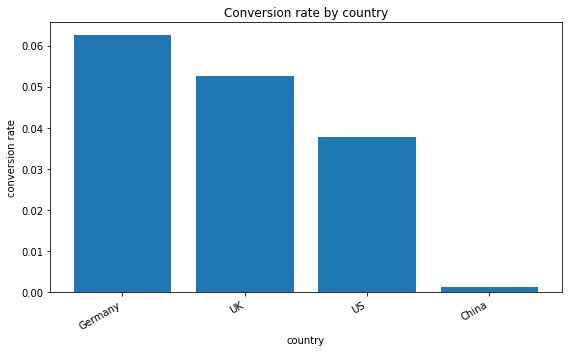

In [15]:
barplot_from_df(cr_by_country.index, cr_by_country.values, "Conversion rate by country", "country", "conversion rate")

In [16]:
# get conversion rate by source and draw the plot
cr_by_source = df.groupby("source")["converted"].mean().sort_values(ascending=False)
cr_by_source

source
Ads       0.034483
Seo       0.032895
Direct    0.028169
Name: converted, dtype: float64

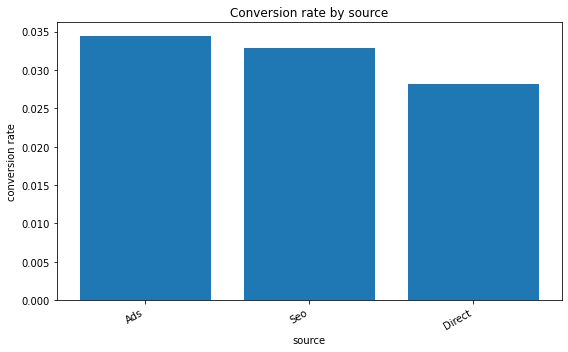

In [17]:
barplot_from_df(cr_by_source.index, cr_by_source.values, "Conversion rate by source", "source", "conversion rate")

In [18]:
# get conversion rate by user and draw the plot
cr_by_newuser = df.groupby("new_user")["converted"].mean()
cr_by_newuser

new_user
0    0.072002
1    0.014021
Name: converted, dtype: float64

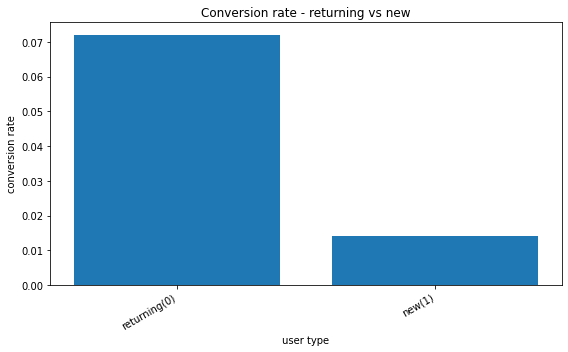

In [19]:
barplot_from_df(["returning(0)","new(1)"], [cr_by_newuser.get(0,0), cr_by_newuser.get(1,0)], "Conversion rate - returning vs new", "user type", "conversion rate")

In [20]:
# get conversion rate for age and # of pages visited in buckets and draw the plot
df["age"].quantile([0, .25, .5, .75, .95, .99, 1.0])

0.00    17.0
0.25    24.0
0.50    30.0
0.75    36.0
0.95    45.0
0.99    52.0
1.00    52.0
Name: age, dtype: float64

C:\Users\yajie\AppData\Local\Temp/ipykernel_45472/3572905948.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cr_by_age_bucket = df.groupby("age_bucket")["converted"].mean()


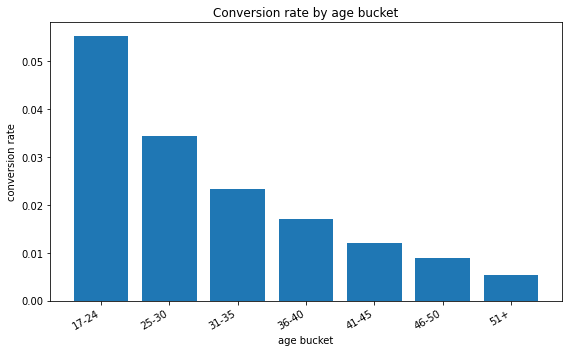

In [21]:
age_bins = [17,24,30,35,40,45,50,60]
age_labels = ["17-24","25-30","31-35","36-40","41-45","46-50","51+"]
df["age_bucket"] = pd.cut(df["age"], bins=age_bins, labels=age_labels, include_lowest=True)
cr_by_age_bucket = df.groupby("age_bucket")["converted"].mean()
barplot_from_df(cr_by_age_bucket.index.astype(str), cr_by_age_bucket.values,
                "Conversion rate by age bucket", "age bucket", "conversion rate")

In [22]:
df["total_pages_visited"].quantile([0, .25, .5, .75, .95, .99, 1.0])

0.00     1.0
0.25     2.0
0.50     4.0
0.75     7.0
0.95    11.0
0.99    17.0
1.00    29.0
Name: total_pages_visited, dtype: float64

C:\Users\yajie\AppData\Local\Temp/ipykernel_45472/3511556872.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cr_by_pages_bucket = df.groupby("pages_bucket")["converted"].mean()


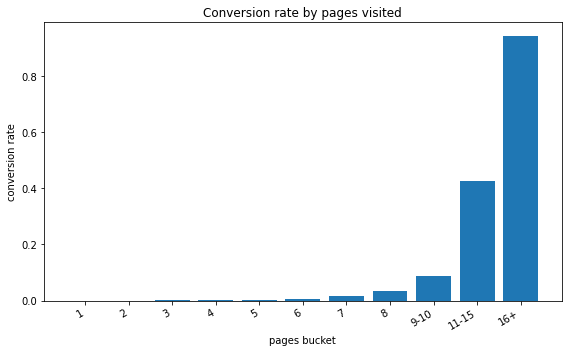

In [23]:
pv_bins = [1,2,3,4,5,6,7,8,9,11,15,30]
pv_labels = ["1","2","3","4","5","6","7","8","9-10","11-15","16+"]
df["pages_bucket"] = pd.cut(df["total_pages_visited"], bins=pv_bins, labels=pv_labels, include_lowest=True)
cr_by_pages_bucket = df.groupby("pages_bucket")["converted"].mean()
barplot_from_df(cr_by_pages_bucket.index.astype(str), cr_by_pages_bucket.values,"Conversion rate by pages visited", "pages bucket", "conversion rate")

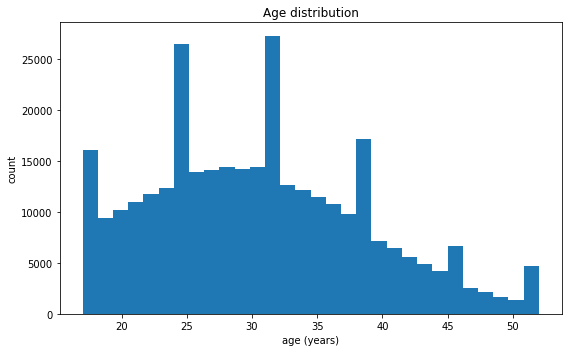

In [24]:
# Distribution histograms
def hist_series(series, title, xlabel):
    plt.figure(figsize=(8,5))
    plt.hist(series.dropna(), bins=30)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()
hist_series(df["age"], "Age distribution", "age (years)")

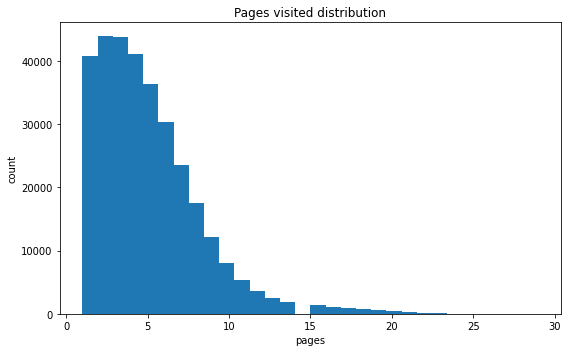

In [25]:
hist_series(df["total_pages_visited"], "Pages visited distribution", "pages")

## 5. Data clssification

In [26]:
# Setup
Features = ["country","source","age","new_user","total_pages_visited"]
Target = "converted"
X = df[Features].copy()
y = df[Target].copy()
categorical = ["country","source"]
numeric = ["age","new_user","total_pages_visited"]
# for logistic model, transform categorical feature into 0/1 indicator for each category and standardization for numeric features.
preprocess_lr = ColumnTransformer([("cat",OneHotEncoder(drop="first", handle_unknown="ignore"),categorical),
                                    ("num", Pipeline(steps=[("scaler", StandardScaler())]), numeric)])
# for Random forest model, transform categorical feature into 0/1 indicator for each category and keep raw data for numeric features.
preprocess_rf = ColumnTransformer([("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical),
                                   ("num", "passthrough", numeric)])
# set up training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

### 5.1 Logisitic regression model

In [27]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",     # handle class imbalance
    solver="lbfgs"
)
pipe_lr = Pipeline([("prep", preprocess_lr), ("clf", log_reg)])
pipe_lr.fit(X_train, y_train)

y_prob_lr = pipe_lr.predict_proba(X_test)[:, 1]
y_pred_lr = (y_prob_lr >= 0.5).astype(int)

roc_auc_lr = roc_auc_score(y_test, y_prob_lr)
ap_lr = average_precision_score(y_test, y_prob_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr, digits=3)
print("\n--- Logistic Regression ---")
print("ROC AUC:", round(roc_auc_lr, 4))
print("Average Precision (PR AUC):", round(ap_lr, 4))
print("\nConfusion matrix @ 0.5:\n", cm_lr)
print("\nClassification report:\n", report_lr)


--- Logistic Regression ---
ROC AUC: 0.986
Average Precision (PR AUC): 0.8429

Confusion matrix @ 0.5:
 [[57596  3604]
 [  123  1917]]

Classification report:
               precision    recall  f1-score   support

           0      0.998     0.941     0.969     61200
           1      0.347     0.940     0.507      2040

    accuracy                          0.941     63240
   macro avg      0.673     0.940     0.738     63240
weighted avg      0.977     0.941     0.954     63240



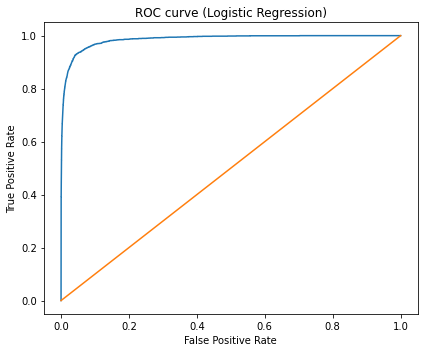

In [28]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_lr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"LR (AUC={roc_auc_lr:.3f})")
plt.plot([0,1],[0,1])
plt.title("ROC curve (Logistic Regression)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.tight_layout(); plt.show()

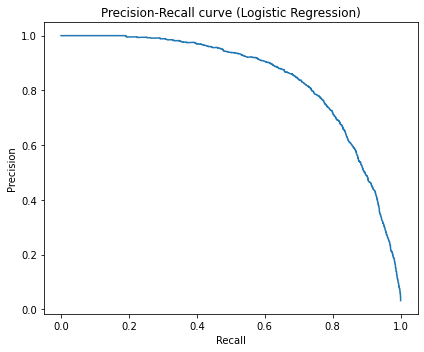

In [29]:
# PR curve
prec, rec, _ = precision_recall_curve(y_test, y_prob_lr)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"LR (AP={ap_lr:.3f})")
plt.title("Precision-Recall curve (Logistic Regression)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.tight_layout(); plt.show()

In [30]:
# Coefficients (after OHE+scaling)
ohe_lr = pipe_lr.named_steps["prep"].named_transformers_["cat"]
cat_names_lr = list(ohe_lr.get_feature_names_out(categorical))
feature_names_lr = cat_names_lr + numeric
coefs = pipe_lr.named_steps["clf"].coef_.flatten()
coef_df = pd.DataFrame({"feature": feature_names_lr, "coef": coefs}).sort_values("coef", ascending=False)
print("\n LR coefficients from positive to negative:")
display(coef_df)


 LR coefficients from positive to negative:


,feature,coef
0,country_Germany,4.007494
1,country_UK,3.703692
2,country_US,3.375559
7,total_pages_visited,2.537719
4,source_Seo,0.006500
3,source_Direct,-0.131269
5,age,-0.576183
6,new_user,-0.788091


### 5.2 Random Forest model

In [31]:
rf = RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced_subsample"
)
pipe_rf = Pipeline([("prep", preprocess_rf), ("clf", rf)])
pipe_rf.fit(X_train, y_train)

y_prob_rf = pipe_rf.predict_proba(X_test)[:, 1]
y_pred_rf = (y_prob_rf >= 0.5).astype(int)

roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
ap_rf = average_precision_score(y_test, y_prob_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, digits=3)

print("\n--- Random Forest ---")
print("ROC AUC:", round(roc_auc_rf, 4))
print("Average Precision (PR AUC):", round(ap_rf, 4))
print("\nConfusion matrix @ 0.5:\n", cm_rf)
print("\nClassification report:\n", report_rf)


--- Random Forest ---
ROC AUC: 0.961
Average Precision (PR AUC): 0.7707

Confusion matrix @ 0.5:
 [[58865  2335]
 [  299  1741]]

Classification report:
               precision    recall  f1-score   support

           0      0.995     0.962     0.978     61200
           1      0.427     0.853     0.569      2040

    accuracy                          0.958     63240
   macro avg      0.711     0.908     0.774     63240
weighted avg      0.977     0.958     0.965     63240



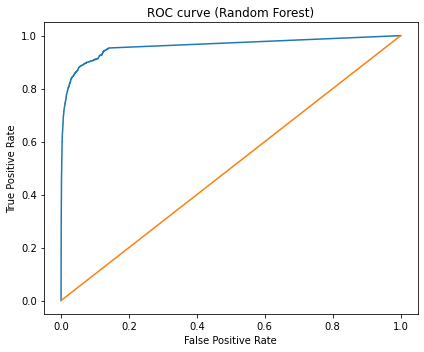

In [32]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"RF (AUC={roc_auc_rf:.3f})")
plt.plot([0,1],[0,1])
plt.title("ROC curve (Random Forest)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.tight_layout(); plt.show()

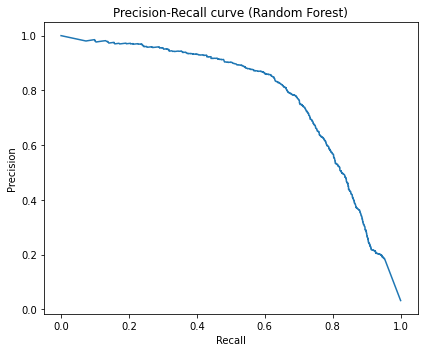

In [33]:
# PR curve
prec, rec, _ = precision_recall_curve(y_test, y_prob_rf)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"RF (AP={ap_rf:.3f})")
plt.title("Precision-Recall curve (Random Forest)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.tight_layout(); plt.show()

In [34]:
# Feature importances
ohe_rf = pipe_rf.named_steps["prep"].named_transformers_["cat"]
cat_names_rf = list(ohe_rf.get_feature_names_out(categorical))
rf_feature_names = cat_names_rf + numeric

rf_importances = pipe_rf.named_steps["clf"].feature_importances_
fi_df = pd.DataFrame({"feature": rf_feature_names, "importance": rf_importances}).sort_values("importance", ascending=False)
print("\nRandom Forest feature importances:")
display(fi_df)


Random Forest feature importances:


,feature,importance
7,total_pages_visited,0.769958
5,age,0.091865
6,new_user,0.080496
2,country_US,0.019414
1,country_UK,0.018260
0,country_Germany,0.014021
4,source_Seo,0.003274
3,source_Direct,0.002713


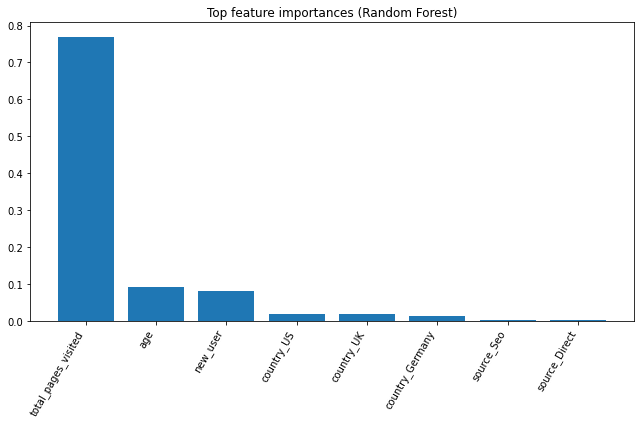

In [35]:
plt.figure(figsize=(9,6))
plt.bar(fi_df["feature"], fi_df["importance"])
plt.title("Top feature importances (Random Forest)")
plt.xticks(rotation=60, ha="right"); plt.tight_layout(); plt.show()

### 5.3 XGBoost Model

In [38]:
!pip install xgboost


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
from xgboost import XGBClassifier

# Use the RF-style preprocessing (OHE for categorical, passthrough numeric)
# If you prefer standardization for numerics, you can swap to preprocess_lr.
xgb = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist"   # fast, scalable
)

pipe_xgb = Pipeline([("prep", preprocess_rf), ("clf", xgb)])
pipe_xgb.fit(X_train, y_train)

y_prob_xgb = pipe_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_prob_xgb >= 0.5).astype(int)

roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)
ap_xgb = average_precision_score(y_test, y_prob_xgb)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb, digits=3)

print("\\n--- XGBoost ---")
print("ROC AUC:", round(roc_auc_xgb, 4))
print("Average Precision (PR AUC):", round(ap_xgb, 4))
print("\\nConfusion matrix @ 0.5:\\n", cm_xgb)
print("\\nClassification report:\\n", report_xgb)

\n--- XGBoost ---
ROC AUC: 0.9853
Average Precision (PR AUC): 0.8376
\nConfusion matrix @ 0.5:\n [[60924   276]
 [  636  1404]]
\nClassification report:\n               precision    recall  f1-score   support

           0      0.990     0.995     0.993     61200
           1      0.836     0.688     0.755      2040

    accuracy                          0.986     63240
   macro avg      0.913     0.842     0.874     63240
weighted avg      0.985     0.986     0.985     63240



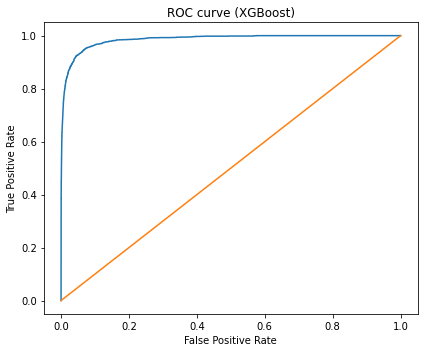

In [42]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"XGB (AUC={roc_auc_xgb:.3f})")
plt.plot([0,1],[0,1])
plt.title("ROC curve (XGBoost)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.tight_layout(); plt.show()

Top XGBoost features:


,feature,importance
7,total_pages_visited,0.666331
6,new_user,0.139846
1,country_UK,0.056413
0,country_Germany,0.054581
2,country_US,0.043343
5,age,0.021488
3,source_Direct,0.009656
4,source_Seo,0.008343


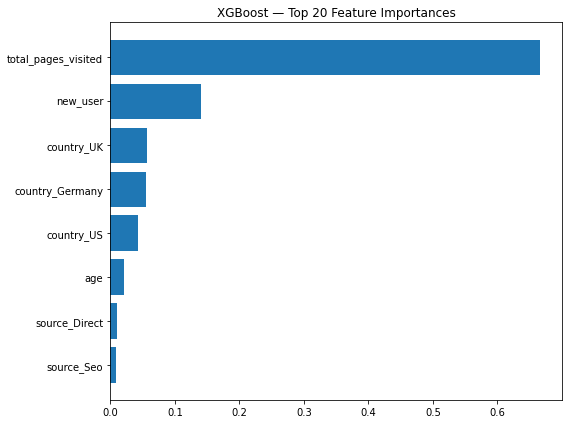

In [40]:
# XGBoost feature importance

# Get the final feature names after preprocessing
# For the RF-style preprocessor: OHE(categorical) + passthrough(numeric)
ohe = pipe_xgb.named_steps["prep"].transformers_[0][1]  # the OneHotEncoder
ohe_features = list(ohe.get_feature_names_out(categorical))
all_features = ohe_features + numeric

importances = pipe_xgb.named_steps["clf"].feature_importances_
# Align lengths (in rare cases, OHE may drop unseen categories)
imp_df = pd.DataFrame({"feature": all_features[:len(importances)], "importance": importances})
top_imp = imp_df.sort_values("importance", ascending=False).head(20)

print("Top XGBoost features:")
display(top_imp)

plt.figure(figsize=(8,6))
plt.barh(top_imp["feature"][::-1], top_imp["importance"][::-1])
plt.title("XGBoost — Top 20 Feature Importances")
plt.tight_layout()
plt.show()

### 5.4 Model comparison

In [45]:
compare_df = pd.DataFrame({
    "model": ["LogisticRegression","RandomForest","XGBoost"],
    "roc_auc": [roc_auc_lr, roc_auc_rf, roc_auc_xgb],
    "avg_precision": [ap_lr, ap_rf,ap_xgb]
})
display(compare_df.sort_values("roc_auc", ascending=False))

,model,roc_auc,avg_precision
0,LogisticRegression,0.985951,0.842901
2,XGBoost,0.985339,0.837556
1,RandomForest,0.960990,0.770731


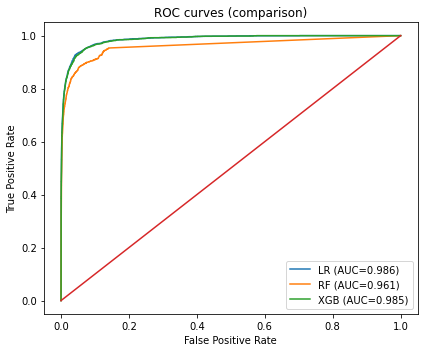

In [46]:
# Combined ROC
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
plt.figure(figsize=(6,5))
plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC={roc_auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={roc_auc_rf:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGB (AUC={roc_auc_xgb:.3f})")
plt.plot([0,1],[0,1])
plt.legend()
plt.title("ROC curves (comparison)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.tight_layout(); plt.show()

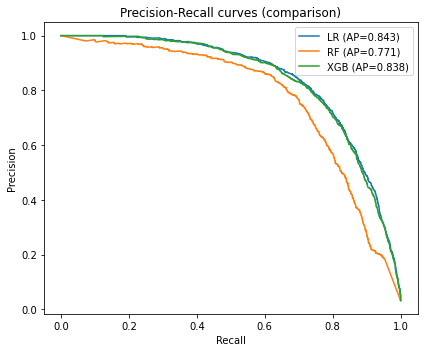

In [48]:
# Combined PR
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_prob_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_prob_rf)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)
plt.figure(figsize=(6,5))
plt.plot(rec_lr, prec_lr, label=f"LR (AP={ap_lr:.3f})")
plt.plot(rec_rf, prec_rf, label=f"RF (AP={ap_rf:.3f})")
plt.plot(rec_xgb, prec_xgb, label=f"XGB (AP={ap_xgb:.3f})")
plt.legend()
plt.title("Precision-Recall curves (comparison)")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.tight_layout(); plt.show()

Based on Three model comparison, Logistic regression model is better with higher ROC AUC and higher PR AUC. 

## 6. Segment discovery: high/low conversion groups

In [37]:
def segment_cr(dataframe, country=None, source=None, new_user=None, min_pages=None, max_pages=None, min_age=None, max_age=None):
    d = dataframe
    if country is not None: d = d[d["country"].isin(country if isinstance(country, list) else [country])]
    if source is not None: d = d[d["source"].isin(source if isinstance(source, list) else [source])]
    if new_user is not None: d = d[d["new_user"].isin(new_user if isinstance(new_user, list) else [new_user])]
    if min_pages is not None: d = d[d["total_pages_visited"] >= min_pages]
    if max_pages is not None: d = d[d["total_pages_visited"] <= max_pages]
    if min_age is not None: d = d[d["age"] >= min_age]
    if max_age is not None: d = d[d["age"] <= max_age]
    if len(d) == 0:
        return None
    return {"n": len(d), "cr": d["converted"].mean()}

min_n = 1000
countries = df["country"].unique().tolist()
sources = df["source"].unique().tolist()

cands = []
for c in countries:
    for s in sources:
        for nu in [0,1]:
            for min_pages in [3,5,7,9]:
                seg = segment_cr(df, country=[c], source=[s], new_user=[nu],
                                 min_pages=min_pages, min_age=25, max_age=45)
                if seg and seg["n"] >= min_n:
                    cands.append({"country":c,"source":s,"new_user":nu,"min_pages":min_pages,
                                  "min_age":25,"max_age":45,"n":seg["n"],"cr":seg["cr"]})

seg_df = pd.DataFrame(cands).sort_values("cr", ascending=False)
display(seg_df.head(10))
display(seg_df.tail(10))

,country,source,new_user,min_pages,min_age,max_age,n,cr
20,US,Ads,0,9,25,45,1723,0.422519
28,US,Seo,0,9,25,45,2896,0.406077
36,US,Direct,0,9,25,45,1332,0.372372
7,UK,Seo,0,7,25,45,1629,0.302640
19,US,Ads,0,7,25,45,3107,0.244609
27,US,Seo,0,7,25,45,5341,0.230856
35,US,Direct,0,7,25,45,2434,0.210764
6,UK,Seo,0,5,25,45,2718,0.184327
1,UK,Ads,0,5,25,45,1439,0.177901
11,UK,Seo,1,9,25,45,1247,0.165196


,country,source,new_user,min_pages,min_age,max_age,n,cr
58,China,Direct,1,7,25,45,1880,0.002660
52,China,Seo,1,7,25,45,4160,0.001923
54,China,Direct,0,3,25,45,2653,0.001885
46,China,Ads,1,7,25,45,2352,0.001701
57,China,Direct,1,5,25,45,3664,0.001638
56,China,Direct,1,3,25,45,5994,0.001001
51,China,Seo,1,5,25,45,7995,0.001001
45,China,Ads,1,5,25,45,4660,0.000858
50,China,Seo,1,3,25,45,13088,0.000611
44,China,Ads,1,3,25,45,7545,0.000530


From the segment analysis, the returning users in US, hearing from Ads, age from 25 to 45, page visited more than 7 times have highest conversion rate.

## 7. Turn scores into actions

In [50]:
# Compare top decile vs others using RF scores 
scores_rf = pd.DataFrame({"p_convert": y_prob_rf, "converted": y_test.values}).reset_index(drop=True)
threshold_top_decile = scores_rf["p_convert"].quantile(0.90)
scores_rf["top_decile_flag"] = (scores_rf["p_convert"] >= threshold_top_decile).astype(int)

uplift = pd.DataFrame({ 
    "group": ["Top 10% score","Bottom 90% score"],
    "n": [int((scores_rf["top_decile_flag"]==1).sum()), int((scores_rf["top_decile_flag"]==0).sum())],
    "avg_score": [scores_rf.loc[scores_rf["top_decile_flag"]==1,"p_convert"].mean(),
                  scores_rf.loc[scores_rf["top_decile_flag"]==0,"p_convert"].mean()],
    "actual_cr": [scores_rf.loc[scores_rf["top_decile_flag"]==1,"converted"].mean(),
                  scores_rf.loc[scores_rf["top_decile_flag"]==0,"converted"].mean()],
})
display(uplift)

,group,n,avg_score,actual_cr
0,Top 10% score,6331,0.663199,0.289370
1,Bottom 90% score,56909,0.010404,0.003655


In [52]:
# Compare top decile vs others using XGBoost scores 
scores_xgb = pd.DataFrame({"p_convert": y_prob_xgb, "converted": y_test.values}).reset_index(drop=True)
threshold_top_decile = scores_xgb["p_convert"].quantile(0.90)
scores_xgb["top_decile_flag"] = (scores_xgb["p_convert"] >= threshold_top_decile).astype(int)

uplift = pd.DataFrame({ 
    "group": ["Top 10% score","Bottom 90% score"],
    "n": [int((scores_xgb["top_decile_flag"]==1).sum()), int((scores_xgb["top_decile_flag"]==0).sum())],
    "avg_score": [scores_xgb.loc[scores_rf["top_decile_flag"]==1,"p_convert"].mean(),
                  scores_xgb.loc[scores_rf["top_decile_flag"]==0,"p_convert"].mean()],
    "actual_cr": [scores_xgb.loc[scores_rf["top_decile_flag"]==1,"converted"].mean(),
                  scores_xgb.loc[scores_rf["top_decile_flag"]==0,"converted"].mean()],
})
display(uplift)

,group,n,avg_score,actual_cr
0,Top 10% score,6326,0.296287,0.289370
1,Bottom 90% score,56914,0.003203,0.003655


In [53]:
# Compare top decile vs others using LR scores
scores_lr = pd.DataFrame({"p_convert": y_prob_lr, "converted": y_test.values}).reset_index(drop=True)
threshold_top_decile = scores_lr["p_convert"].quantile(0.90)
scores_lr["top_decile_flag"] = (scores_lr["p_convert"] >= threshold_top_decile).astype(int)

uplift = pd.DataFrame({ 
    "group": ["Top 10% score","Bottom 90% score"],
    "n": [int((scores_lr["top_decile_flag"]==1).sum()), int((scores_lr["top_decile_flag"]==0).sum())],
    "avg_score": [scores_lr.loc[scores_rf["top_decile_flag"]==1,"p_convert"].mean(),
                  scores_lr.loc[scores_rf["top_decile_flag"]==0,"p_convert"].mean()],
    "actual_cr": [scores_lr.loc[scores_rf["top_decile_flag"]==1,"converted"].mean(),
                  scores_lr.loc[scores_rf["top_decile_flag"]==0,"converted"].mean()],
})
display(uplift)

# Export scored test set (both models) for activation
scored = pd.DataFrame({
    "p_convert_rf": y_prob_rf,
    "p_convert_lr": y_prob_lr,
    "p_convert_xgb": y_prob_xgb,
    "actual_converted": y_test.values
})
out_path = r"C:\Users\yajie\OneDrive\Desktop\ztgg\Conversion rate\scored_testset.csv"
scored.to_csv(out_path, index=False)
print("Wrote:", out_path)

,group,n,avg_score,actual_cr
0,Top 10% score,6324,0.664610,0.289370
1,Bottom 90% score,56916,0.053559,0.003655


Wrote: C:\Users\yajie\OneDrive\Desktop\ztgg\Conversion rate\scored_testset.csv


## 8.Conclusions and next steps

The site is working very well for young users. Definitely let’s tell marketing to advertise and use channels which are more likely to reach young people.

The site is working very well for Germany in terms of conversion. But the summary showed that there are few Germans coming to the site: way less than UK, despite a larger population. Again, marketing should get more Germans. Big opportunity.

Users with old accounts do much better. Targeted emails with offers to bring them back to the site could be a good idea to try.

Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the local culture, or maybe some payment issue. Given how many users are based in China, fixing this should be a top priority. Huge opportunity.

As you can see, product ideas usually end up being about:

Identify segments that perform well, but have low absolute count (like Germany). Then tell marketing to get more of those people

Tell product to fix the experience for the bad performing ones

Bad performing segments with high absolute count (like China) usually provide the biggest opportunities for massive gains, if you can guess why that’s happening and then build a test to validate your hypothesis